Solving 4x4_21.jpg (4x4)...
Computing compatibility matrices...
Strategy: Beam Search


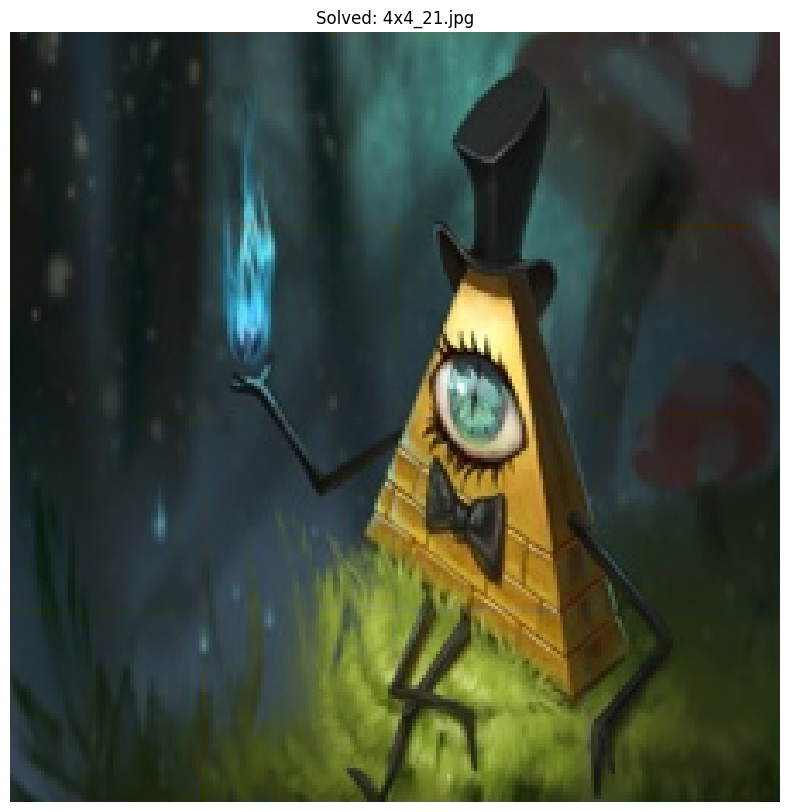

Solving 8x8_46.jpg (8x8)...
Computing compatibility matrices...
Strategy: Greedy + Local Optimization
Starting Local Optimization. Initial Score: 105.15
Converged.
Strategy: Greedy + Local Optimization
Starting Local Optimization. Initial Score: 105.15
Converged.


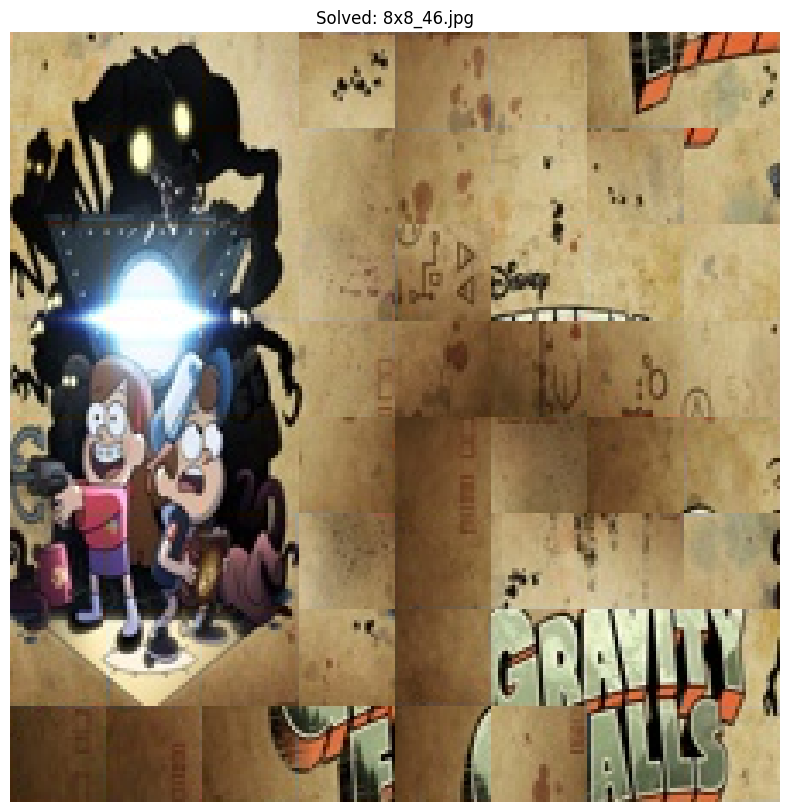

In [14]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import heapq
import random
import itertools

# --- 1. Feature Extraction & Similarity Metric ---

def extract_borders(img):
    """
    Extracts the 4 borders of a puzzle piece image.
    Returns a dictionary with keys 'top', 'bottom', 'left', 'right'.
    """
    h, w, _ = img.shape
    return {
        'top': img[0, :, :],      # Shape (w, 3)
        'bottom': img[-1, :, :],  # Shape (w, 3)
        'left': img[:, 0, :],     # Shape (h, 3)
        'right': img[:, -1, :]    # Shape (h, 3)
    }

def calculate_nssd(edge_a, edge_b):
    """
    Normalized Sum of Squared Differences (NSSD).
    Score ranges from 0 (dissimilar) to 1 (identical).
    """
    # Ensure same length (handle slight pixel mismatches if any, though usually square)
    if len(edge_a) != len(edge_b):
        min_len = min(len(edge_a), len(edge_b))
        edge_a = edge_a[:min_len]
        edge_b = edge_b[:min_len]
        
    edge_a = edge_a.astype(np.float32)
    edge_b = edge_b.astype(np.float32)
    
    diff = edge_a - edge_b
    norm_diff = np.sum(diff ** 2)
    norm_a = np.sum(edge_a ** 2)
    norm_b = np.sum(edge_b ** 2)
    
    epsilon = 1e-6
    score = 1 - (norm_diff / (norm_a + norm_b + epsilon))
    return score

def compute_compatibility_matrices(pieces):
    """
    Computes Horizontal (H) and Vertical (V) compatibility matrices.
    H[i][j] = Similarity(piece_i.right, piece_j.left)
    V[i][j] = Similarity(piece_i.bottom, piece_j.top)
    """
    n = len(pieces)
    H = np.zeros((n, n))
    V = np.zeros((n, n))
    
    borders = [extract_borders(p) for p in pieces]
    
    for i in range(n):
        for j in range(n):
            if i == j: 
                H[i, j] = -1.0
                V[i, j] = -1.0
                continue
            
            # Horizontal: i | j  (i's right matches j's left)
            H[i, j] = calculate_nssd(borders[i]['right'], borders[j]['left'])
            
            # Vertical: i / j (i's bottom matches j's top)
            V[i, j] = calculate_nssd(borders[i]['bottom'], borders[j]['top'])
            
    return H, V

# --- 2. Solvers ---

def calculate_board_score(board, H, V, grid_size):
    """Calculates the total compatibility score of a grid configuration."""
    score = 0.0
    # Horizontal links
    for r in range(grid_size):
        for c in range(grid_size - 1):
            p1 = board[r * grid_size + c]
            p2 = board[r * grid_size + c + 1]
            if p1 is not None and p2 is not None:
                score += H[p1, p2]
                
    # Vertical links
    for r in range(grid_size - 1):
        for c in range(grid_size):
            p1 = board[r * grid_size + c]
            p2 = board[(r + 1) * grid_size + c]
            if p1 is not None and p2 is not None:
                score += V[p1, p2]
    return score

def solve_backtracking(n_pieces, H, V):
    """
    Exact solver for small puzzles (2x2, 3x3).
    Uses recursion with pruning to find the permutation with max score.
    """
    grid_size = int(np.sqrt(n_pieces))
    best_score = -1.0
    best_board = None
    
    # Pre-compute valid candidates to speed up? 
    # For N=3 (9 pieces), 9! = 362k, feasible to just brute force with slight pruning.
    
    used = [False] * n_pieces
    current_board = [None] * n_pieces
    
    def backtrack(idx, current_score):
        nonlocal best_score, best_board
        
        if idx == n_pieces:
            if current_score > best_score:
                best_score = current_score
                best_board = list(current_board)
            return

        r, c = idx // grid_size, idx % grid_size
        
        # Optimization: If current partial score is already too far behind best, prune?
        # (Skipping complex pruning for simplicity on small N)

        for p_id in range(n_pieces):
            if not used[p_id]:
                # Calculate score contribution
                score_inc = 0.0
                valid = True
                
                # Check Left Neighbor
                if c > 0:
                    left_p = current_board[idx - 1]
                    s = H[left_p, p_id]
                    if s < 0.1: valid = False # Hard prune on very bad matches
                    score_inc += s
                
                # Check Top Neighbor
                if r > 0:
                    top_p = current_board[idx - grid_size]
                    s = V[top_p, p_id]
                    if s < 0.1: valid = False
                    score_inc += s
                
                if valid:
                    used[p_id] = True
                    current_board[idx] = p_id
                    backtrack(idx + 1, current_score + score_inc)
                    current_board[idx] = None
                    used[p_id] = False

    backtrack(0, 0.0)
    return best_board

def solve_beam_search(n_pieces, H, V, beam_width=100):
    """
    Beam Search for medium puzzles (4x4, 5x5).
    Maintains top K partial solutions.
    """
    grid_size = int(np.sqrt(n_pieces))
    
    # State: (score, [list_of_placed_piece_ids], set_of_used_ids)
    # Start with empty board
    beam = [(0.0, [], set())] 
    
    for step in range(n_pieces):
        new_beam = []
        r, c = step // grid_size, step % grid_size
        
        for score, board, used in beam:
            # Try adding every unused piece
            for p_id in range(n_pieces):
                if p_id not in used:
                    new_score = score
                    
                    # Check Left
                    if c > 0:
                        left_p = board[-1]
                        new_score += H[left_p, p_id]
                        
                    # Check Top
                    if r > 0:
                        top_p = board[step - grid_size]
                        new_score += V[top_p, p_id]
                    
                    new_board = board + [p_id]
                    new_used = used.copy()
                    new_used.add(p_id)
                    new_beam.append((new_score, new_board, new_used))
        
        # Keep top K
        # Note: heapq is min-heap, so we use nlargest
        beam = heapq.nlargest(beam_width, new_beam, key=lambda x: x[0])
        
        # Print progress
        # if step % 5 == 0: print(f"Step {step}/{n_pieces}, Best Score: {beam[0][0]:.2f}")

    return beam[0][1] # Return board of best state

def solve_greedy_local(n_pieces, H, V):
    """
    Greedy placement followed by Local Optimization (Hill Climbing) for large puzzles (8x8+).
    """
    grid_size = int(np.sqrt(n_pieces))
    
    # --- Phase 1: Greedy Initialization ---
    # Simple raster scan greedy: Place (0,0), then best match for (0,1), etc.
    # Better: Prim's-like expansion? Let's stick to raster scan with beam-width 1 logic for simplicity
    # or just reuse Beam Search with small width (e.g., 10) which is effectively greedy but smarter.
    
    # Let's use a randomized greedy start to avoid getting stuck in one bad seed
    best_greedy_board = None
    best_greedy_score = -1
    
    # Try a few random starts
    for _ in range(5):
        used = set()
        board = [None] * n_pieces
        
        # Pick random seed for (0,0)
        seed = random.randint(0, n_pieces - 1)
        board[0] = seed
        used.add(seed)
        
        current_score = 0
        
        for i in range(1, n_pieces):
            r, c = i // grid_size, i % grid_size
            best_p = -1
            best_inc = -float('inf')
            
            for p in range(n_pieces):
                if p not in used:
                    inc = 0
                    if c > 0: inc += H[board[i-1], p]
                    if r > 0: inc += V[board[i-grid_size], p]
                    
                    if inc > best_inc:
                        best_inc = inc
                        best_p = p
            
            board[i] = best_p
            used.add(best_p)
            current_score += best_inc
            
        if current_score > best_greedy_score:
            best_greedy_score = current_score
            best_greedy_board = board

    board = list(best_greedy_board)
    current_score = best_greedy_score
    
    # --- Phase 2: Local Optimization (Hill Climbing) ---
    # Swap two tiles, check if score improves
    
    max_iter = 10000
    no_improv_limit = 1000
    no_improv = 0
    
    print(f"Starting Local Optimization. Initial Score: {current_score:.2f}")
    
    for it in range(max_iter):
        # Pick two random indices
        idx1, idx2 = random.sample(range(n_pieces), 2)
        
        # Calculate score change
        # We only need to check the neighbors of idx1 and idx2
        
        def get_local_score(idx, p_id):
            r, c = idx // grid_size, idx % grid_size
            s = 0
            # Left
            if c > 0: s += H[board[idx-1], p_id]
            # Right
            if c < grid_size - 1: s += H[p_id, board[idx+1]]
            # Top
            if r > 0: s += V[board[idx-grid_size], p_id]
            # Bottom
            if r < grid_size - 1: s += V[p_id, board[idx+grid_size]]
            return s

        # Score BEFORE swap
        s_before = get_local_score(idx1, board[idx1]) + get_local_score(idx2, board[idx2])
        
        # Perform Swap in temp
        board[idx1], board[idx2] = board[idx2], board[idx1]
        
        # Score AFTER swap
        s_after = get_local_score(idx1, board[idx1]) + get_local_score(idx2, board[idx2])
        
        if s_after > s_before:
            # Keep swap
            current_score += (s_after - s_before)
            no_improv = 0
            # print(f"Iter {it}: Improved to {current_score:.2f}")
        else:
            # Revert swap
            board[idx1], board[idx2] = board[idx2], board[idx1]
            no_improv += 1
            
        if no_improv > no_improv_limit:
            print("Converged.")
            break
            
    return board

# --- 3. Main Pipeline ---

def solve_puzzle_lab2(target_image_name):
    # Configuration
    json_path = r"Tests/test_001/extractor_runs/20251213_033802/descriptors.json"
    image_dir = r"Tests/test_001/images"
    
    # 1. Load Data
    if not os.path.exists(json_path):
        print("JSON not found.")
        return
    with open(json_path, 'r') as f:
        descriptors = json.load(f)
        
    samples = [d for d in descriptors if d['source_image'] == target_image_name]
    samples.sort(key=lambda x: x['id'])
    
    if not samples:
        print(f"No descriptors for {target_image_name}")
        return
        
    img_path = os.path.join(image_dir, target_image_name)
    full_image = cv2.imread(img_path)
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    
    # 2. Extract Pieces
    pieces = []
    for sample in samples:
        bbox = sample['bbox']
        x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        crop = full_image[y:y+h, x:x+w]
        pieces.append(crop)
        
    n_pieces = len(pieces)
    grid_size = int(np.sqrt(n_pieces))
    print(f"Solving {target_image_name} ({grid_size}x{grid_size})...")
    
    # 3. Compute Compatibility
    print("Computing compatibility matrices...")
    H, V = compute_compatibility_matrices(pieces)
    
    # 4. Select Strategy
    solution_indices = []
    if grid_size <= 3:
        print("Strategy: Exact Backtracking")
        solution_indices = solve_backtracking(n_pieces, H, V)
    elif grid_size <= 5:
        print("Strategy: Beam Search")
        solution_indices = solve_beam_search(n_pieces, H, V, beam_width=200)
    else:
        print("Strategy: Greedy + Local Optimization")
        solution_indices = solve_greedy_local(n_pieces, H, V)
        
    # 5. Visualize
    if not solution_indices:
        print("Failed to find solution.")
        return

    h_p, w_p, _ = pieces[0].shape
    canvas = np.zeros((grid_size * h_p, grid_size * w_p, 3), dtype=np.uint8)
    
    for idx, p_id in enumerate(solution_indices):
        if p_id is None: continue
        r, c = idx // grid_size, idx % grid_size
        canvas[r*h_p:(r+1)*h_p, c*w_p:(c+1)*w_p] = pieces[p_id]
        
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(f"Solved: {target_image_name}")
    plt.axis('off')
    plt.show()

# Example Usage
solve_puzzle_lab2("4x4_21.jpg")
solve_puzzle_lab2("8x8_46.jpg")


Solving 8x8_105.jpg (8x8)...
Computing compatibility matrices (LAB)...
Strategy: Best-First Growing


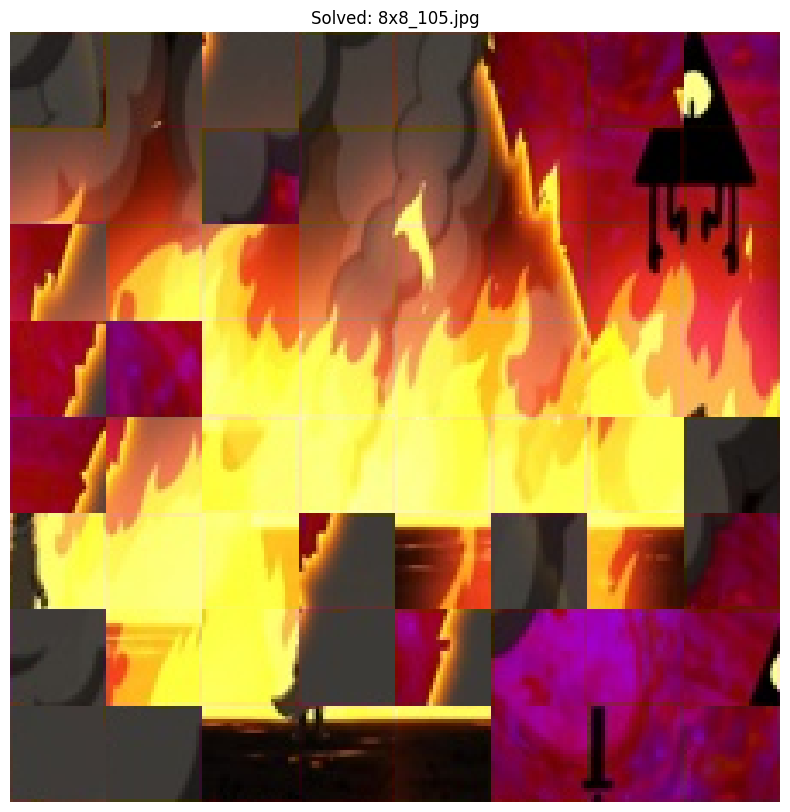

In [11]:
solve_puzzle_lab2("8x8_105.jpg")